# Assignment3. Cifar10 Hyperparameter Tuning with MLP  

이 과제에서는 cifar10 데이터셋에 대해서 MLP를 이용한 10-way Classification을 해볼 겁니다!  
데이터의 차원이 3072 dimension이 된 만큼 MNIST보다는 쉽지 않겠죠?  

특히 이번 과제는 각종 Regularization 기법들과 Optimizer등이 이미 구현되어 있는 코드(작성자에게 칭찬..!)를 통해서 직접 다양한 하이퍼파라미터들이 성능에 어떤 영향을 미치는지 체험해보셨으면 해요. 

### 만약 **제가 하이퍼파라미터를 튜닝한다면** 일반적으로..  

1. 레이어 수랑 히든 유닛 수를 조절해서 적절한 (성능이 나오면서 파라미터 수는 작은) Model Capacity를 찾구요  
2. Learning Rate를 조절하면서 적절한 속도로 학습이 되는 값을 찾습니다. (값이 너무 크면 loss가 요동치거나 발산합니다)
3. Dropout과 l2 값을 조절하면서 Overfitting을 최대한 줄여보구요.  
4. BatchNormalization과 Xavier Initialization을 껐다 켜보면서 성능 변화가 어느 정도 일어나는지 확인해봅니다.  

이런 식으로 4~5개 정도의 실험을 거치면서 점점 하이퍼파라미터 영역을 좁혀나가면 그나마 안정적으로 값을 올릴 수 있었던 것 같습니다 :)  
시간이 되시는 분들은 Random Search를 해봐도 재밌을 것 같네요!(하지만 시각화는 쉽지 않겠죠?)

그리고 추가로..  

1. Optimizer를 바꿔보세요!  
2. Activation Function을 바꿔보세요!  

### 실험이 다 끝나셨다면  

각 실험의 그림과 결과도 유지해주시고 주피터 노트북(.ipynb) 파일의 끝 부분에 최종적으로 찾은 2개의 하이퍼파라미터 조합과 그때의 Train/Validation/Test Accuracy를 리포트해주세요! 

그리고 [과제 제출 및 피드백 링크](https://goo.gl/forms/XQHdElHCueyCwfoi2)를 통해 제출해주시면 감사하겠습니다 :)

<hr>  

# 시작하기

[제가 미리 만들어놓은 이 링크](https://colab.research.google.com/github/heartcored98/Standalone-DeepLearning/blob/master/Lec4/Assignment3_cifar10_MLP.ipynb)를 통해 Colab에서 바로 작업하실 수 있습니다!  
만약 코드가 알록달록 하지 않다면(Syntax Highlighting이 안 된다면)  
그냥 새로운 python3, GPU 런타임으로 Colab 파일을 만드신 후 코드를 복붙하시는게 빠를 겁니다.   

<hr>

아래 코드를 통해 Colab에 연결되어 있는 서버 컴퓨터 내에 결과들을 저장할 results 폴더를 만들어봅시다.  
만약 이미 만들었다면 **File exists** 와 같은 에러가 뜨면서 새로운 폴더 생성이 불가능할텐데 폴더만 있다면 괜찮으니 넘어가줍시다.  

In [0]:
!mkdir results

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns 
import matplotlib.pyplot as plt

## Data Preparation

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified


## Model Architecture

In [0]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier
        
        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
                
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act == nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')
        
        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()
          
    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            if self.use_bn: x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
            
net = MLP(3072, 10, 100, 4, 'relu', 0.1, True, True) # Testing Model Construction

## Train, Validate, Test and Experiment

In [0]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()
    optimizer.zero_grad()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 3072)
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [0]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [0]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [0]:
def experiment(partition, args):
  
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    else:
        raise ValueError('In-valid optimizer choice')
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

# Manage Experiment Result

In [0]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

# Visualization Utility

In [0]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

## Experiment1. N_layer vs Hidden_Dim

In [0]:
# ====== Random Seed Initialization ====== #
seeds = [123, 456, 789]
np.random.seed(seeds[0])
torch.manual_seed(seeds[0])

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_layer_hid_dim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'
args.n_layer = 5

# ====== Regularization ======= #
args.dropout = 0.0
args.use_bn = False
args.l2 = 0.0
args.use_xavier = False
args.weight_decay = 0.1

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #

def grid_hyperparameter_tuning(default_namespace, independent_variables):
    
    namespace = deepcopy(default_namespace)
    if len(independent_variables) == 2:
        list_var1 = list(independent_variables.values())[0]
        list_var2 = list(independent_variables.values())[1]
        list_key = list(independent_variables.keys())
        for var1 in list_var1:
            for var2 in list_var2:
                setattr(namespace, list_key[0], var1)
                setattr(namespace, list_key[1], var2)
                #print(namespace)
                
                setting, result = experiment(partition, deepcopy(namespace))
                save_exp_result(setting, result)
                
    elif len(independent_variables) == 1:
        list_var1 = list(independent_variables.values())[0]
        key = list(independent_variables.keys())[0]
        for var1 in list_var1:
            setattr(namespace, key, var1)
            
            setting, result = experiment(partition, deepcopy(namespace))
            save_exp_result(setting, result)
    else:
        raise ValueError("independent_variables need at most 2 length")



In [45]:
# ====== n_layer, hid_dim testing ====== #
grid_hyperparameter_tuning(args, {"n_layer":[2, 4, 6], "hid_dim":[16, 64, 256]})
args.exp_name = "exp1r_n_layer_hid_dim"
for i in range(10):
    args.hid_dim = 2 ** np.random.randint(4, 9)
    args.n_layer = np.random.randint(1, 8)

    setting, result = experiment(partition, deepcopy(args))
    save_exp_result(setting, result)

Epoch 0, Acc(train/val): 17.86/15.12, Loss(train/val) 2.27/2.36. Took 9.06 sec
Epoch 1, Acc(train/val): 11.88/10.65, Loss(train/val) 2.30/2.30. Took 10.42 sec
Epoch 2, Acc(train/val): 11.62/11.51, Loss(train/val) 2.28/2.28. Took 10.45 sec
Epoch 3, Acc(train/val): 13.12/10.14, Loss(train/val) 2.29/2.32. Took 10.40 sec
Epoch 4, Acc(train/val): 9.97/10.13, Loss(train/val) 2.31/2.31. Took 10.42 sec
Epoch 5, Acc(train/val): 9.90/9.85, Loss(train/val) 2.31/2.31. Took 10.33 sec
Epoch 6, Acc(train/val): 9.97/9.65, Loss(train/val) 2.30/2.31. Took 10.47 sec
Epoch 7, Acc(train/val): 10.01/9.85, Loss(train/val) 2.30/2.30. Took 10.40 sec
Epoch 8, Acc(train/val): 9.91/9.65, Loss(train/val) 2.30/2.30. Took 10.36 sec
Epoch 9, Acc(train/val): 10.12/9.85, Loss(train/val) 2.30/2.30. Took 10.40 sec
Epoch 0, Acc(train/val): 15.34/9.84, Loss(train/val) 2.32/2.31. Took 10.33 sec
Epoch 1, Acc(train/val): 9.91/10.07, Loss(train/val) 2.31/2.30. Took 10.37 sec
Epoch 2, Acc(train/val): 10.04/10.34, Loss(train/val

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


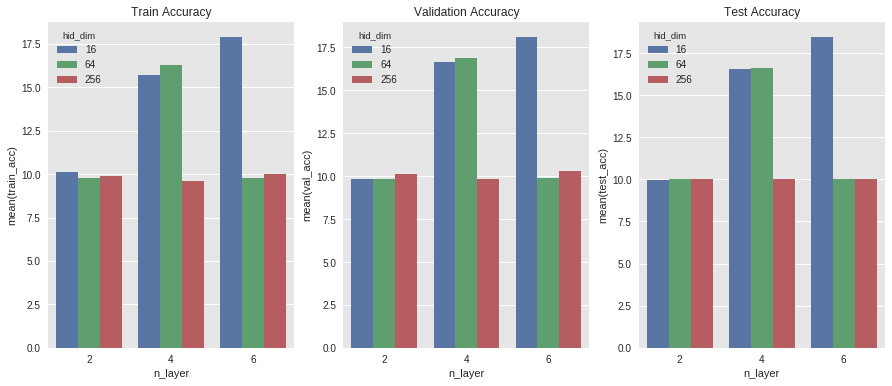

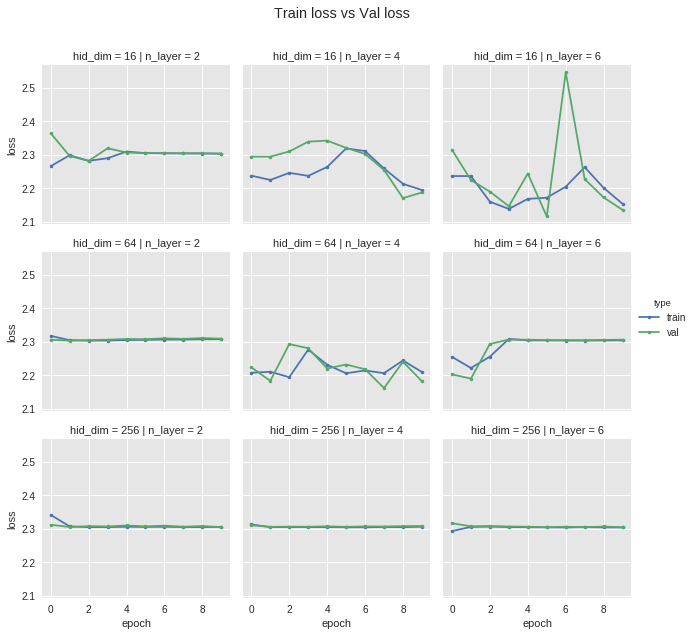

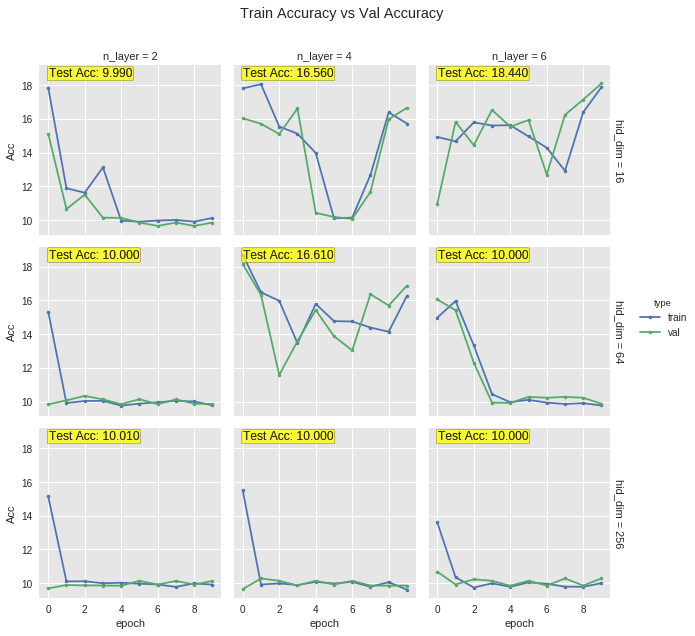

In [48]:
var1 = 'n_layer'
var2 = 'hid_dim'
df = load_exp_result('exp1_n_layer_hid_dim')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=True) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.

In [51]:
display(load_exp_result('exp1r_n_layer_hid_dim'))

,act,dropout,exp_name,hid_dim,in_dim,l2,lr,n_layer,optim,out_dim,test_acc,train_acc,train_accs,train_batch_size,train_losses,use_bn,use_xavier,val_acc,val_accs,val_losses
0,relu,0.0,exp1r_n_layer_hid_dim,128,3072,0.0,0.0015,7,Adam,10,10.00,9.8325,"[13.03, 11.405, 9.7625, 9.91, 9.58, 10.0825, 9...",256,"[2.284956491676865, 2.3090984654274718, 2.3057...",False,False,9.87,"[10.51, 9.84, 9.92, 10.14, 10.13, 9.65, 10.13,...","[2.3034220218658445, 2.307981538772583, 2.3069..."
1,relu,0.0,exp1r_n_layer_hid_dim,64,3072,0.0,0.0015,7,Adam,10,10.13,10.0250,"[13.425, 11.795, 12.9875, 14.2275, 14.1225, 14...",256,"[2.273209854296059, 2.275855664235012, 2.25096...",False,False,10.41,"[10.95, 11.14, 11.49, 15.38, 13.06, 15.94, 15....","[2.310527968406677, 2.2950205326080324, 2.2799..."
2,relu,0.0,exp1r_n_layer_hid_dim,32,3072,0.0,0.0015,7,Adam,10,13.12,16.2025,"[15.0075, 13.475, 15.45, 15.4225, 16.1825, 16....",256,"[2.232806561099496, 2.225108603762973, 2.22744...",False,False,12.84,"[10.67, 18.14, 15.87, 16.09, 16.13, 17.37, 16....","[2.2872921943664553, 2.1603987216949463, 2.224..."
3,relu,0.0,exp1r_n_layer_hid_dim,64,3072,0.0,0.0015,4,Adam,10,15.91,15.9250,"[16.415, 12.37, 14.295, 16.3075, 16.03, 15.585...",256,"[2.2689170047735714, 2.290459787769682, 2.2522...",False,False,15.78,"[15.64, 9.9, 17.23, 15.86, 16.39, 14.84, 16.07...","[2.239029788970947, 2.3039535999298097, 2.1938..."
4,relu,0.0,exp1r_n_layer_hid_dim,32,3072,0.0,0.0015,1,Adam,10,14.67,17.4425,"[18.3625, 15.2775, 16.615, 15.615, 16.435, 17....",256,"[8.481138054732304, 26.90179317012714, 40.6696...",False,False,14.69,"[11.1, 14.65, 14.18, 16.79, 16.75, 14.59, 15.3...","[24.000959205627442, 47.15915145874023, 68.138..."
5,relu,0.0,exp1r_n_layer_hid_dim,64,3072,0.0,0.0015,5,Adam,10,16.96,14.8150,"[15.485, 14.1075, 12.1825, 15.8725, 16.1775, 1...",256,"[2.2571526530441965, 2.279355282996111, 2.2845...",False,False,17.08,"[13.47, 15.98, 16.01, 16.72, 16.71, 15.24, 14....","[2.305473732948303, 2.2195966482162475, 2.2765..."
6,relu,0.0,exp1r_n_layer_hid_dim,16,3072,0.0,0.0015,2,Adam,10,11.49,12.4725,"[15.7575, 11.6775, 10.7575, 10.265, 10.005, 10...",256,"[2.414863399639251, 2.2956176031926634, 2.2916...",False,False,11.20,"[11.66, 11.32, 10.23, 10.21, 10.02, 10.42, 9.8...","[2.302174925804138, 2.2911551237106322, 2.3025..."
7,relu,0.0,exp1r_n_layer_hid_dim,32,3072,0.0,0.0015,4,Adam,10,16.34,15.9350,"[16.5875, 14.8, 12.425, 12.64, 10.7625, 15.832...",256,"[2.267087005505896, 2.2698328586141017, 2.2820...",False,False,16.65,"[15.16, 12.37, 9.41, 11.21, 13.56, 10.14, 9.87...","[2.3218093633651735, 2.265982246398926, 2.3523..."


In [58]:
# ====== lr,  testing ====== #
args.n_layer = 5
args.hid_dim = 256
args.exp_name = "exp2_lr_decay_rate"
grid_hyperparameter_tuning(args, {"lr":[.1, .01, .001, .0001, .00001], "decay_rate":[.05, .1, .15, .2]})

Epoch 0, Acc(train/val): 9.86/9.65, Loss(train/val) 637425997.83/5.74. Took 9.84 sec
Epoch 1, Acc(train/val): 10.05/9.62, Loss(train/val) 59861572841.02/173501077.60. Took 10.82 sec
Epoch 2, Acc(train/val): 10.13/9.85, Loss(train/val) 4830522661.53/6.24. Took 10.78 sec
Epoch 3, Acc(train/val): 10.04/9.65, Loss(train/val) 70249417563.73/6.22. Took 10.79 sec
Epoch 4, Acc(train/val): 9.92/9.86, Loss(train/val) 26239615606.63/4.48. Took 10.85 sec
Epoch 5, Acc(train/val): 10.07/9.65, Loss(train/val) 32674751373.93/3.82. Took 10.86 sec
Epoch 6, Acc(train/val): 9.98/10.03, Loss(train/val) 10475406544.70/475047032.00. Took 10.82 sec
Epoch 7, Acc(train/val): 9.89/10.23, Loss(train/val) 5828120564.73/3.99. Took 10.78 sec
Epoch 8, Acc(train/val): 9.88/9.93, Loss(train/val) 5.09/4516674.60. Took 10.81 sec
Epoch 9, Acc(train/val): 10.35/9.92, Loss(train/val) 988128.80/5.76. Took 10.83 sec
Epoch 0, Acc(train/val): 10.11/9.63, Loss(train/val) 141735428.58/626998.64. Took 10.82 sec
Epoch 1, Acc(train/

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


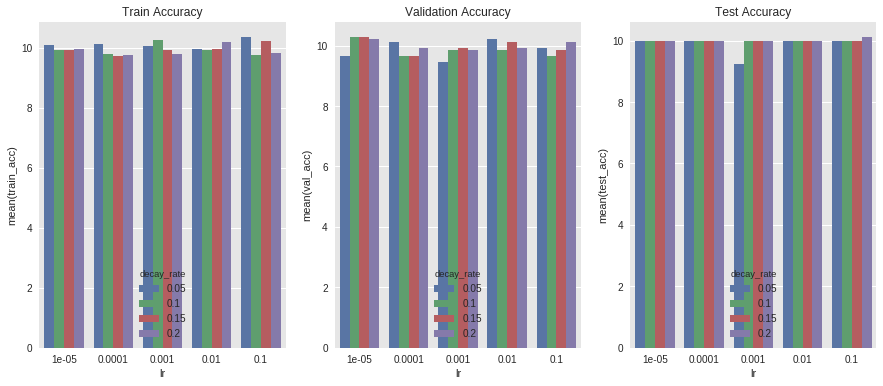

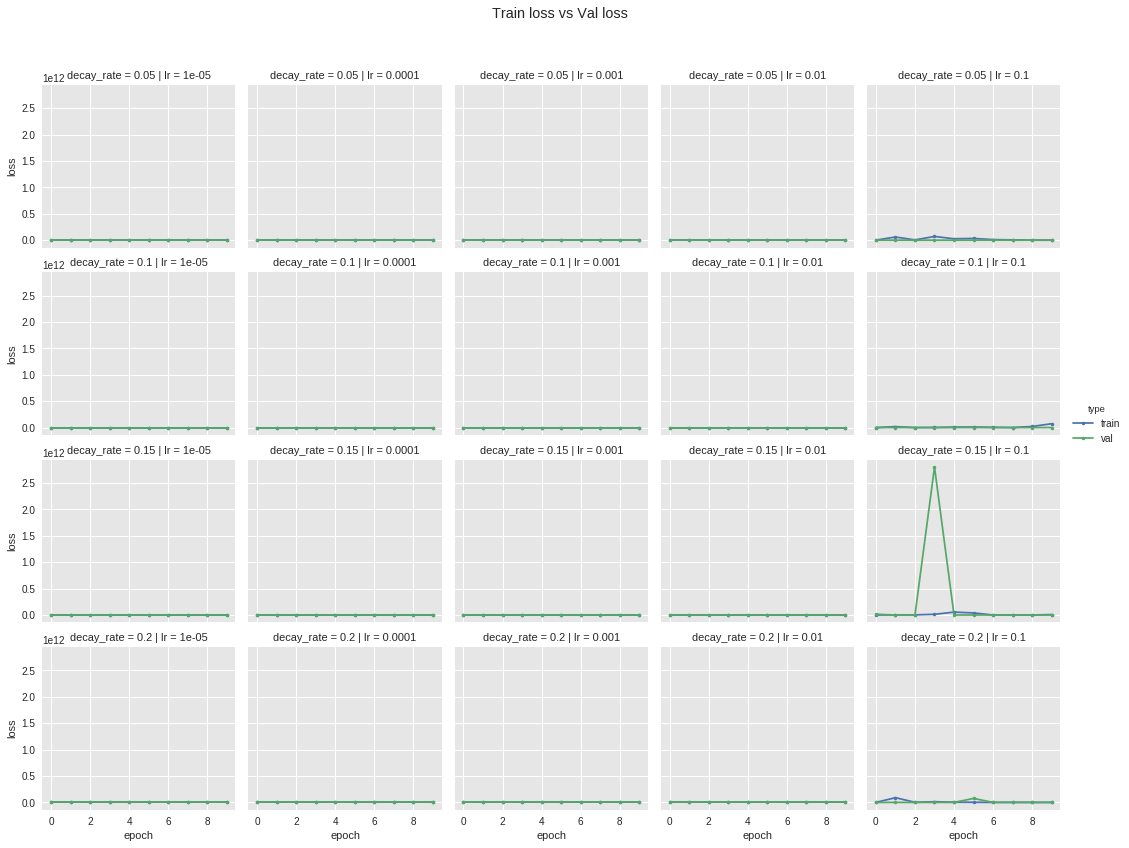

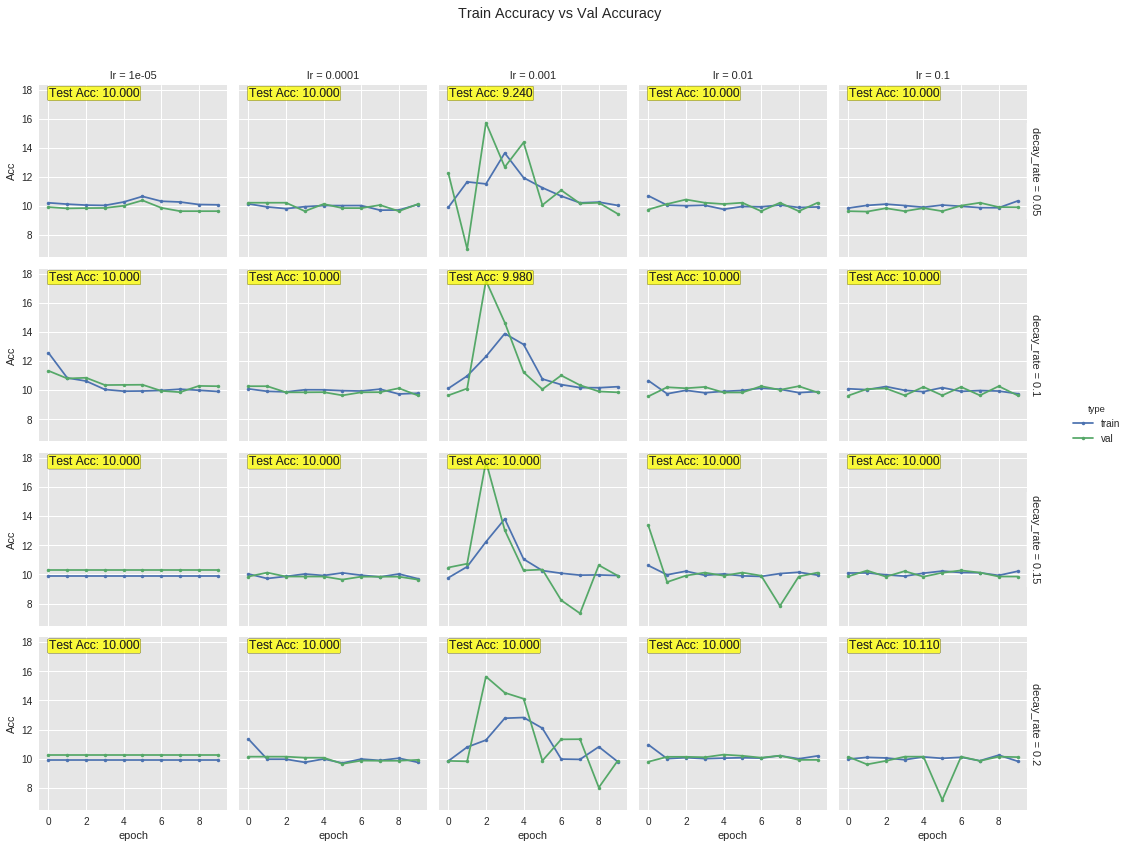

In [59]:
var1 = 'lr'
var2 = 'decay_rate'
df = load_exp_result('exp2_lr_decay_rate')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=True) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.

In [0]:
# ====== lr,  testing ====== #
args.exp_name = "exp2_1_lr_decay_rate"
grid_hyperparameter_tuning(args, {"lr":[.0031, .0056, .01, .018, .031], "decay_rate":[.05]})

Epoch 0, Acc(train/val): 11.88/11.90, Loss(train/val) 2.62/5.53. Took 9.88 sec
Epoch 1, Acc(train/val): 11.04/9.97, Loss(train/val) 26.85/54.51. Took 10.90 sec
Epoch 2, Acc(train/val): 10.12/9.85, Loss(train/val) 50.50/2.36. Took 10.81 sec
Epoch 3, Acc(train/val): 9.99/10.22, Loss(train/val) 44.33/112.05. Took 10.85 sec
Epoch 4, Acc(train/val): 10.11/10.23, Loss(train/val) 72.04/2.32. Took 10.81 sec
Epoch 5, Acc(train/val): 9.97/10.10, Loss(train/val) 13.73/2.33. Took 10.79 sec
Epoch 6, Acc(train/val): 9.92/10.28, Loss(train/val) 5.15/2.33. Took 10.74 sec
Epoch 7, Acc(train/val): 10.06/10.13, Loss(train/val) 2.52/2.33. Took 10.81 sec
Epoch 8, Acc(train/val): 10.23/9.63, Loss(train/val) 2.61/2.33. Took 10.77 sec
Epoch 9, Acc(train/val): 9.99/8.80, Loss(train/val) 2.92/4.06. Took 10.73 sec
Epoch 0, Acc(train/val): 11.10/9.56, Loss(train/val) 30.53/201.53. Took 10.73 sec
Epoch 1, Acc(train/val): 10.14/10.20, Loss(train/val) 2595.78/41.97. Took 10.76 sec
Epoch 2, Acc(train/val): 10.16/9.65

In [0]:
var1 = 'lr'
var2 = 'decay_rate'
df = load_exp_result('exp2_1_lr_decay_rate')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=True) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.

In [0]:
#args.lr = 
#args.decay_rate = 
# ====== L2, Dropout Test ====== #
args.exp_name = "exp3_l2_dropout"
grid_hyperparameter_tuning(args, {"l2":[.00001, .001, .1, 10], "dropout":[0, .2, .4]})
args.exp_name = "exp3r_l2_dropout"
for i in range(10):
    args.l2 = .1 ** np.random.randint(5)
    args.dropout = .1 * np.random.randint(5)

    setting, result = experiment(partition, deepcopy(args))
    save_exp_result(setting, result)

In [0]:
#args.l2 = 
#args.dropout = 
# ====== batchnormal, xavierinit Test ====== #
args.exp_name = "exp4_batch_xavier_init"
grid_hyperparameter_tuning(args, {"use_bn":[True, False], "use_xavier":[True, False]})